Sistem Rekomendasi Musik

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn librosa


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import Library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Correct imports
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, ndcg_score
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa
import librosa.display as lplt
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity

# Setting a seed for reproducibility
seed = 12
np.random.seed(seed)


In [2]:
# Masukkan Dataset ke path
file_path = '/home/codespace/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/features_30_sec.csv'

try:
    df = pd.read_csv(file_path)
    df.head()
except FileNotFoundError:
    print(f"File not found at the specified path: {file_path}")

In [3]:
# Index Dataset
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (1000, 60)
Count of Positive and Negative samples


,label,count
0,blues,100
1,classical,100
2,country,100
3,disco,100
4,hiphop,100
5,jazz,100
6,metal,100
7,pop,100
8,reggae,100
9,rock,100


In [4]:
# Contoh dataset
audio_fp = '/home/codespace/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [5]:
# Ensure IPython is imported
import IPython.display as ipd

# Assuming you have variables `audio_data` and `sr` defined
# Example:
# audio_data, sr = librosa.load('path_to_audio_file.wav', sr=None)

# Play the audio
ipd.Audio(audio_data, rate=sr)


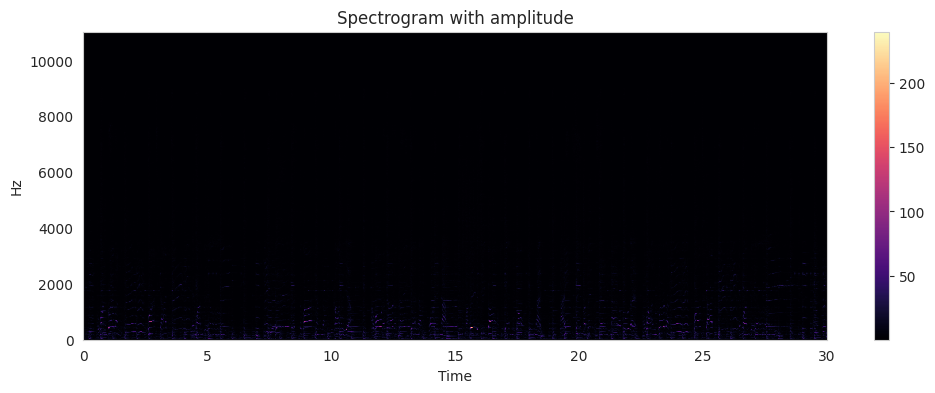

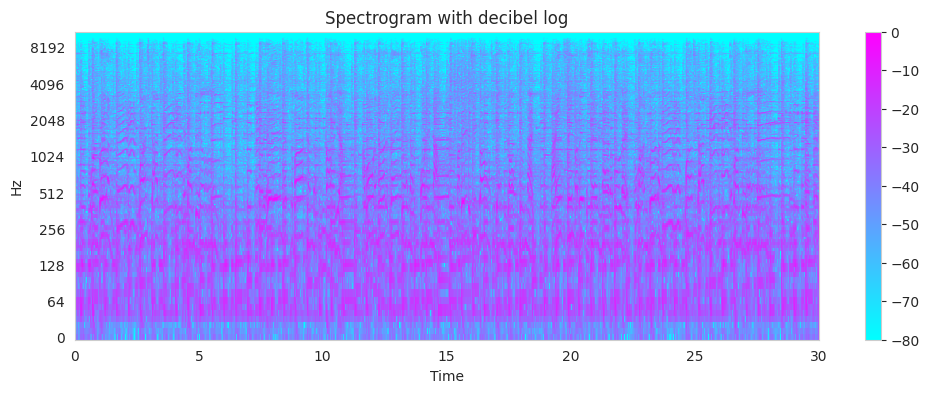

In [6]:
# Spectogram
n_fft = 2048
hop_length = 512

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

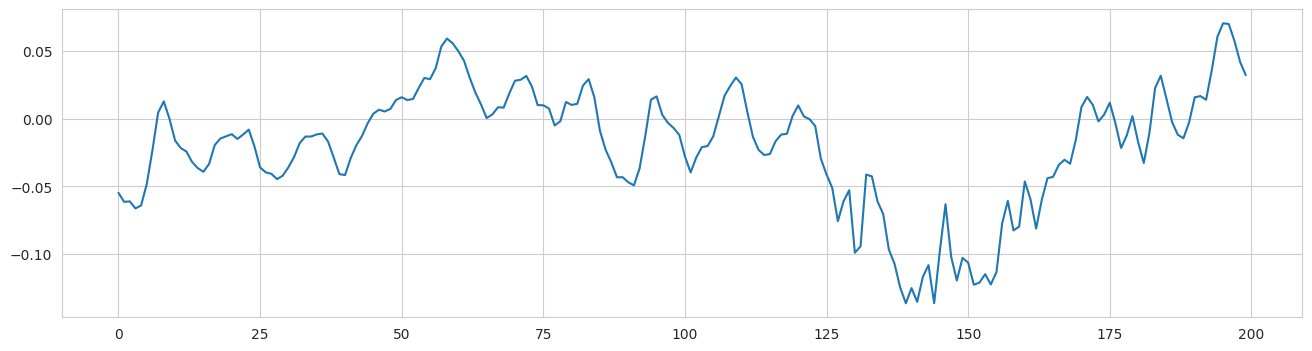

In [7]:
# Plot Audio Wave
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

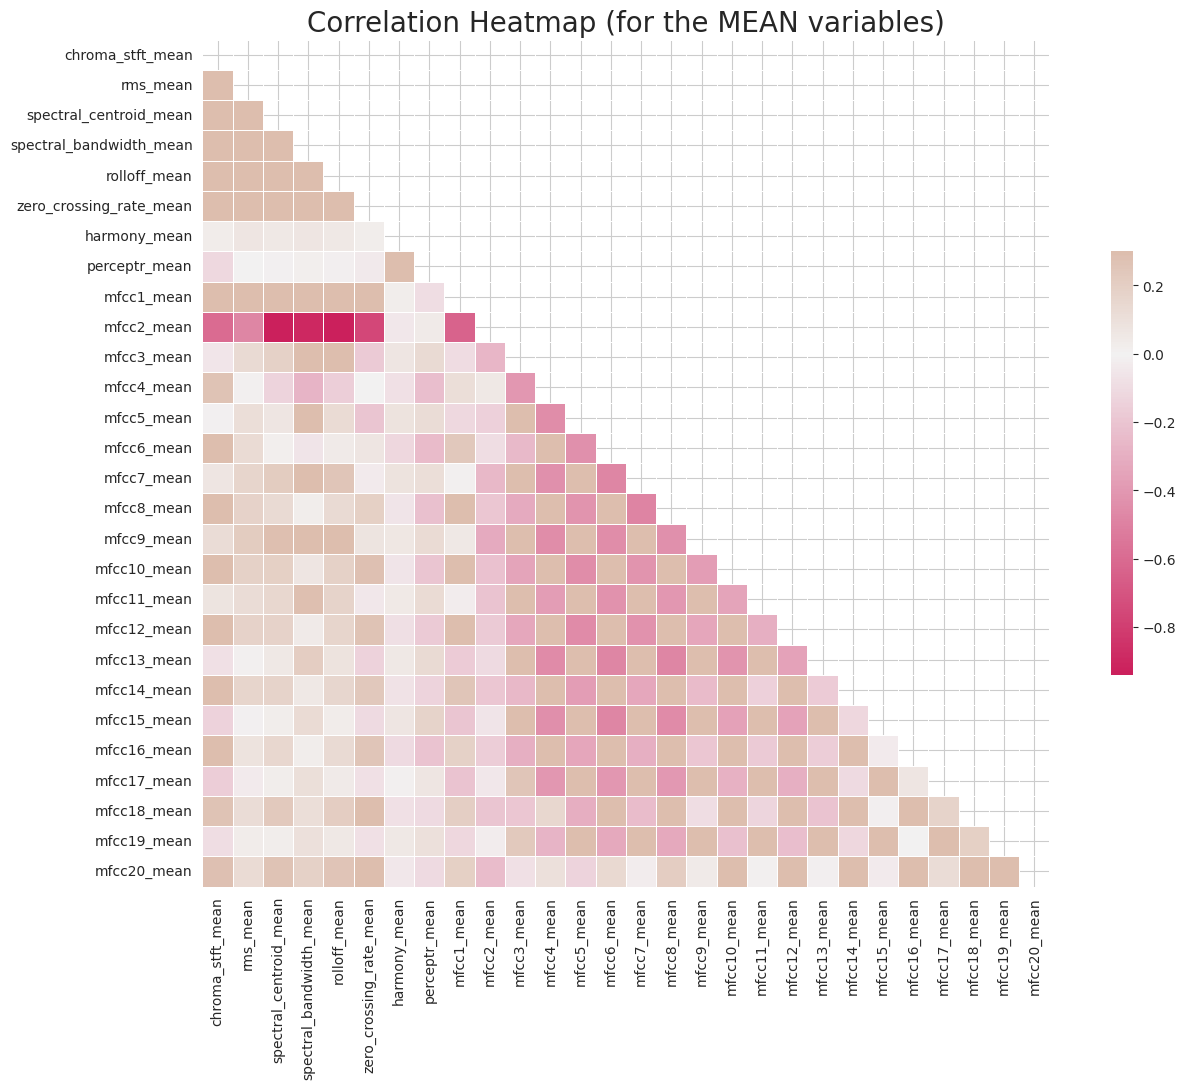

In [8]:
# Hitung Matrix Korelasi untuk fitur-fitur dari Dataset
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Plot Heatmap
f, ax = plt.subplots(figsize=(16, 11));
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

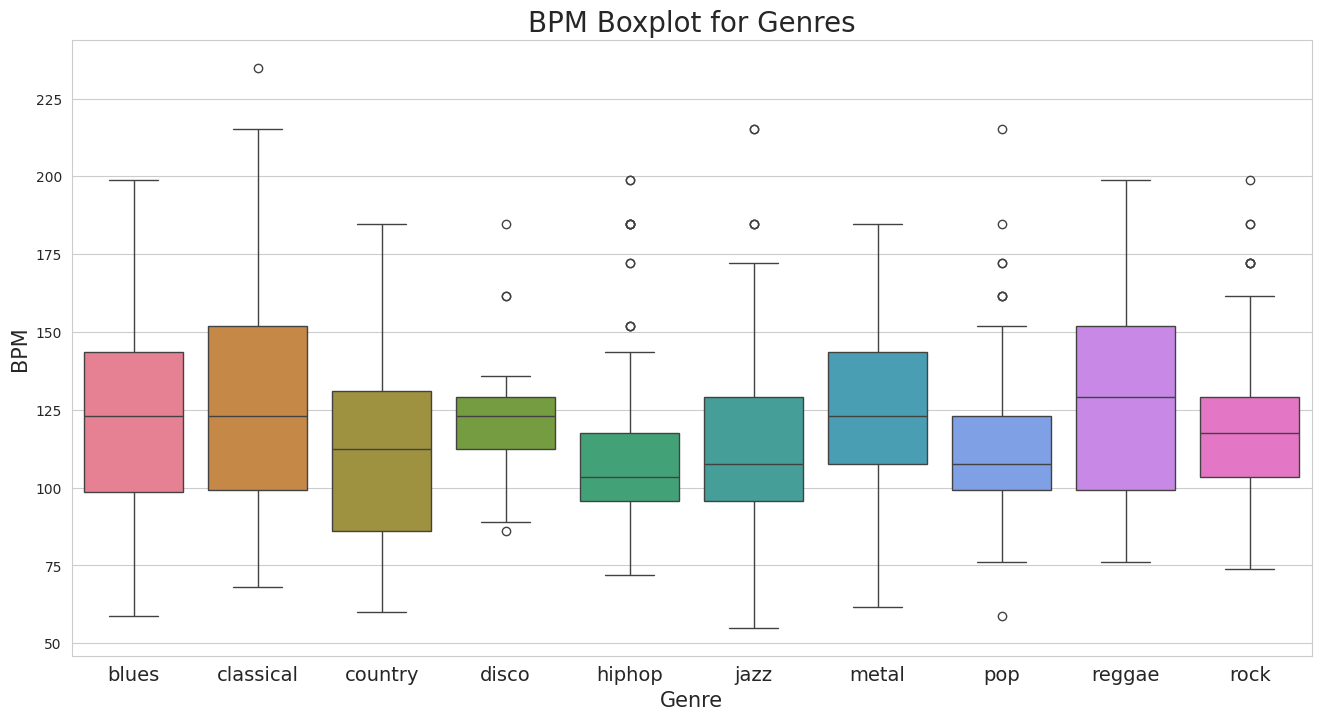

In [9]:
# Boxplot Genre berdasarkan BPM
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

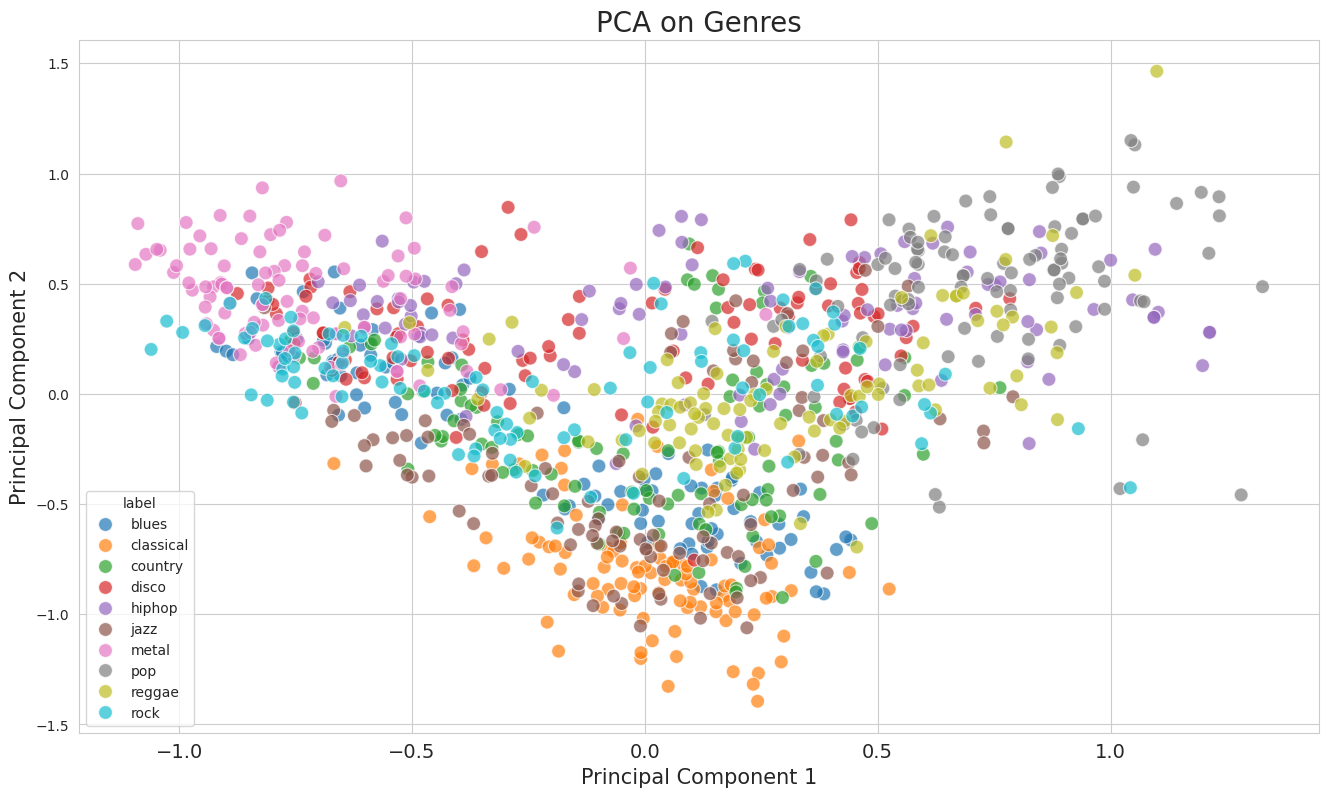

In [10]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# Normalisasi Data
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Mencari 2 Komponen PCA Teratas
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# Menggabungkan ke Label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [11]:
# Mencari kolom dengan nilai NA / Kosong
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [12]:
# Mapping index label
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [13]:
# Merubah label di dataset menjadi berbentuk index
df.label = [label_index[l] for l in df.label]

In [14]:
# Mengacak sample
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [15]:
# Drop kolom yang tidak relevan
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# Splitting data
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [16]:
# Menampilkan hasil split data
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 700 records out of 1000 which is 70%
Dev set has 198 records out of 1000 which is 20%
Test set has 102 records out of 1000 which is 10%


In [17]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.0
10.1010101010101
9.803921568627452


In [18]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [19]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

2024-12-04 07:58:13.784169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 07:58:13.820555: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 07:58:14.168186: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 07:58:14.439625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733299094.864549    2529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733299095.02

TF version:- 2.18.0


In [20]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs,
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [21]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

2024-12-04 07:58:33.859533: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,650 (221.29 KB)

 Trainable params: 56,650 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.1696 - loss: 2.2223 - val_accuracy: 0.3333 - val_loss: 1.9338
Epoch 2/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4192 - loss: 1.7935 - val_accuracy: 0.4040 - val_loss: 1.6426
Epoch 3/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5134 - loss: 1.4873 - val_accuracy: 0.4848 - val_loss: 1.3925
Epoch 4/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6022 - loss: 1.2336 - val_accuracy: 0.5707 - val_loss: 1.2233
Epoch 5/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6776 - loss: 1.0318 - val_accuracy: 0.6111 - val_loss: 1.1291
Epoch 6/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7132 - loss: 0.8888 - val_accuracy: 0.6364 - val_loss: 1.0585
Epoch 7/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7425 - loss: 0.7766 - val_accuracy: 0.6667 - val_loss: 1.0012
Epoch 8/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7826 - loss: 0.6767 - val_accuracy: 0.6970 - val_loss: 0.9507
Epoch 9/70


Max. Validation Accuracy 0.7676767706871033


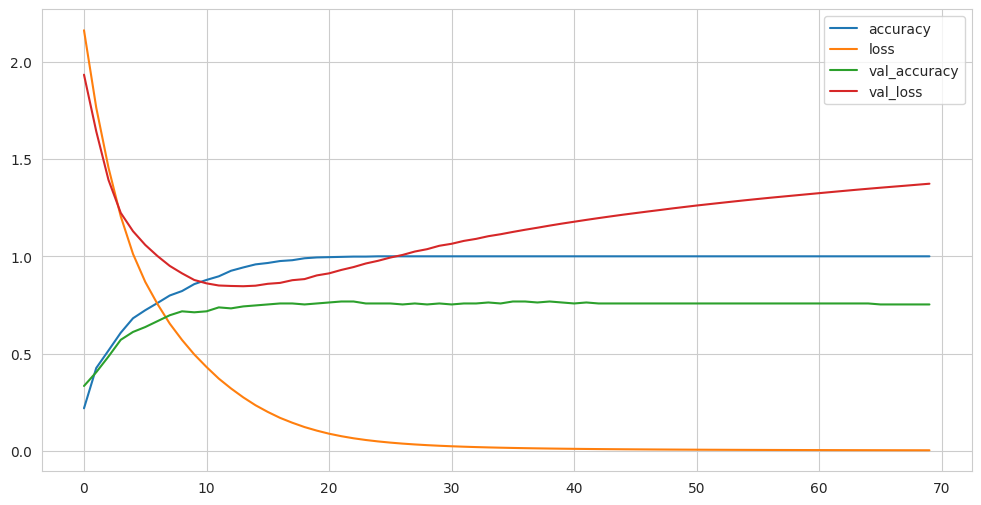

In [22]:
plotHistory(model_1_history)

In [23]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.1884 - loss: 2.2342 - val_accuracy: 0.3687 - val_loss: 1.8815
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3530 - loss: 1.8648 - val_accuracy: 0.4091 - val_loss: 1.6019
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4295 - loss: 1.6326 - val_accuracy: 0.5000 - val_loss: 1.3798
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4839 - loss: 1.4361 - val_accuracy: 0.5253 - val_loss: 1.2635
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5253 - loss: 1.3522 - val_accuracy: 0.5354 - val_loss: 1.2150
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5631 - loss: 1.2166 - val_accuracy: 0.5707 - val_loss: 1.1230
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6196 - loss: 1.0853 - val_accuracy: 0.6566 - val_loss: 1.0290
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6709 - loss: 0.9880 - val_accuracy: 0.6667 - val_

Max. Validation Accuracy 0.7929292917251587


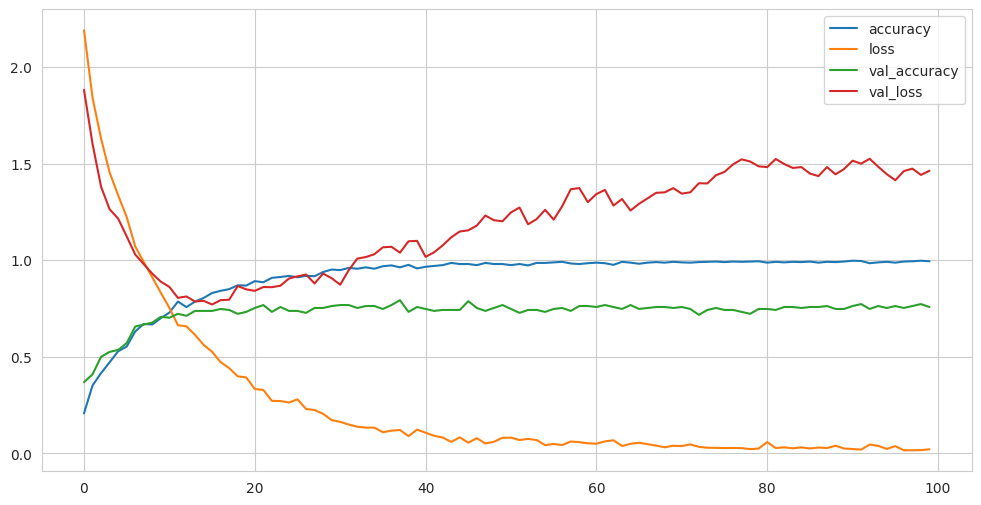

In [25]:
plotHistory(model_2_history)

In [26]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.0834 - loss: 2.3778 - val_accuracy: 0.1162 - val_loss: 2.3343
Epoch 2/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0913 - loss: 2.3457 - val_accuracy: 0.1263 - val_loss: 2.3096
Epoch 3/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1070 - loss: 2.3435 - val_accuracy: 0.1414 - val_loss: 2.2873
Epoch 4/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1189 - loss: 2.2970 - val_accuracy: 0.1465 - val_loss: 2.2646
Epoch 5/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1327 - loss: 2.2950 - val_accuracy: 0.1717 - val_loss: 2.2438
Epoch 6/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1377 - loss: 2.2646 - val_accuracy: 0.1970 - val_loss: 2.2235
Epoch 7/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1652 - loss: 2.2562 - val_accuracy: 0.2525 - val_loss: 2.2041
Epoch 8/700
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1827 - loss: 2.2464 - val_accuracy: 0.2778 - val

Max. Validation Accuracy 0.7929292917251587


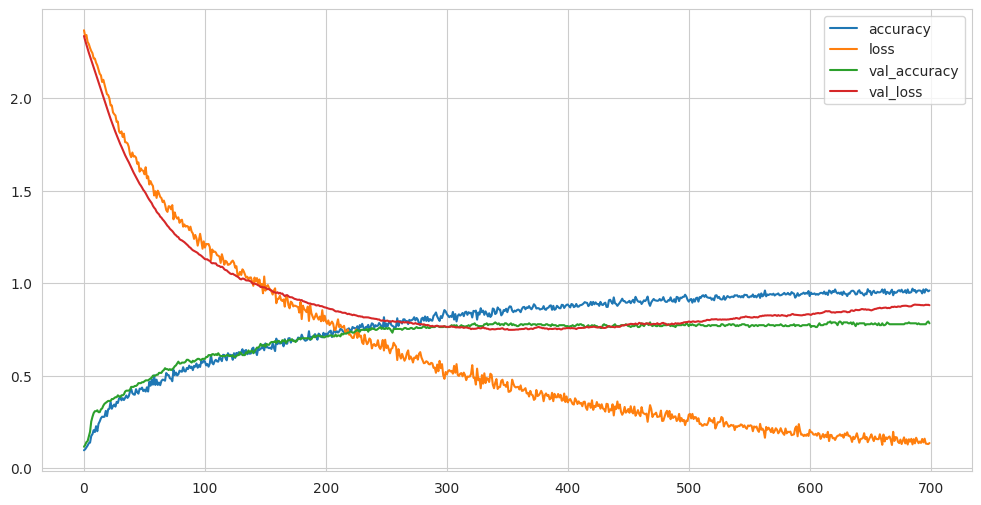

In [27]:
plotHistory(model_3_history)

In [28]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),

    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1024)           │        59,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.1567 - loss: 2.2601 - val_accuracy: 0.3737 - val_loss: 1.8284
Epoch 2/500
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3173 - loss: 1.8811 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3197 - loss: 1.8779 - val_accuracy: 0.4747 - val_loss: 1.6481
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3931 - loss: 1.6841 - val_accuracy: 0.5152 - val_loss: 1.3943
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4651 - loss: 1.5534 - val_accuracy: 0.5707 - val_loss: 1.2686
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4969 - loss: 1.4323 - val_accuracy: 0.5707 - val_loss: 1.2299
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5124 - loss: 1.3539 - val_accuracy: 0.6061 - val_loss: 1.1001
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5427 - loss: 1.2916 - val_accuracy: 0.6010 - val_loss: 1.1744
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5672 - loss: 1.2046 - val_accuracy: 0.6313 - val_loss: 1.0837
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5792 - loss: 1.1224 - val_accuracy: 0.5808 - val_loss: 1.1129
Epoc

Max. Validation Accuracy 0.8030303120613098


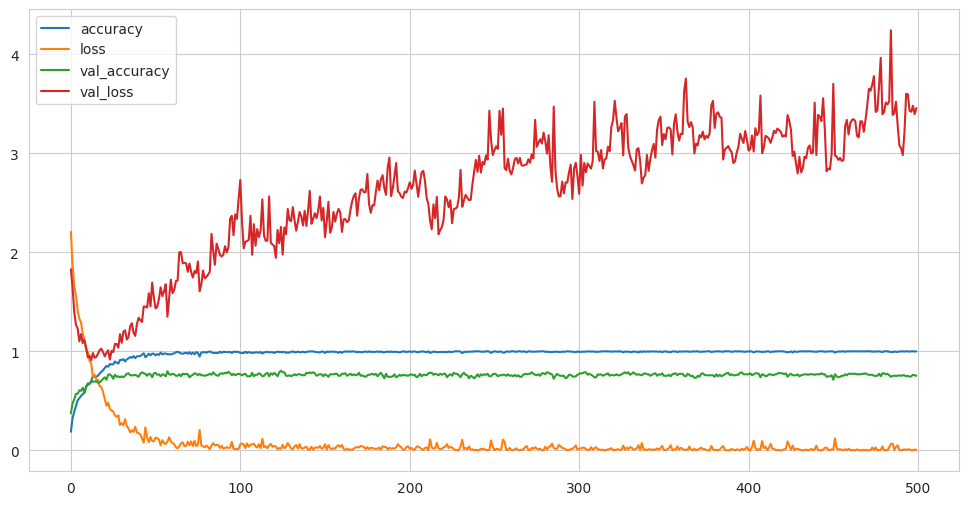

In [29]:
plotHistory(model_4_history)

In [30]:
test_loss, test_acc  = model_1.evaluate(X_test, y_test, batch_size=128)
print("Evaluasi Model 1")
print("Loss :",test_loss)
print("\nAkurasi :",test_acc*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7059 - loss: 1.4212
Evaluasi Model 1
Loss : 1.4212089776992798

Akurasi : 70.58823704719543


In [31]:
test_loss, test_acc  = model_2.evaluate(X_test, y_test, batch_size=128)
print("Evaluasi Model 2")
print("Loss :",test_loss)
print("\nAkurasi :",test_acc*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7451 - loss: 1.7339
Evaluasi Model 2
Loss : 1.7339067459106445

Akurasi : 74.50980544090271


In [32]:
test_loss, test_acc  = model_3.evaluate(X_test, y_test, batch_size=128)
print("Evaluasi Model 3")
print("Loss :",test_loss)
print("\nAkurasi :",test_acc*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7451 - loss: 0.9630
Evaluasi Model 3
Loss : 0.963009774684906

Akurasi : 74.50980544090271


In [33]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("Evaluasi Model 4")
print("Loss :",test_loss)
print("\nAkurasi :",test_acc*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7451 - loss: 2.7490
Evaluasi Model 4
Loss : 2.7490155696868896

Akurasi : 74.50980544090271


**Content Based Recommender System**

In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import keras as k

In [37]:
# Assuming we have chosen model_2 as the best model based on test accuracy.
best_model = model_4

In [38]:
# We will use the model's second last layer for feature extraction

feature_extractor = k.models.Model(inputs=best_model.input, outputs=best_model.layers[-2].output)

AttributeError: The layer sequential_3 has never been called and thus has no defined input.

In [54]:
# Recreate the feature extraction model more explicitly
feature_extractor = k.models.Sequential(best_model.layers[:-1])

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs,
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),

    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')
" resultat : Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1024)           │        59,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 757,322 (2.89 MB)"


test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("Evaluasi Model 4")
print("Loss :",test_loss)
print("\nAkurasi :",test_acc*100)

resultat "1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7451 - loss: 2.7490
Evaluasi Model 4
Loss : 2.7490155696868896

Akurasi : 74.50980544090271"

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import keras as k

# Assuming we have chosen model_4 as the best model based on test accuracy.
best_model = model_4

# We will use the model's second last layer for feature extraction

feature_extractor = k.models.Model(inputs=best_model.input, outputs=best_model.layers[-2].output)

the issue is when i run this "feature_extractor = k.models.Model(inputs=best_model.input, outputs=best_model.layers[-2].output)" i get this issue "---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[38], line 3
      1 # We will use the model's second last layer for feature extraction
----> 3 feature_extractor = k.models.Model(inputs=best_model.input, outputs=best_model.layers[-2].output)

File /usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/ops/operation.py:254, in Operation.input(self)
    244 @property
    245 def input(self):
    246     """Retrieves the input tensor(s) of a symbolic operation.
    247 
    248     Only returns the tensor(s) corresponding to the *first time*
   (...)
    252         Input tensor or list of input tensors.
    253     """
--> 254     return self._get_node_attribute_at_index(0, "input_tensors", "input")

File /usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/ops/operation.py:285, in Operation._get_node_attribute_at_index(self, node_index, attr, attr_name)
    269 """Private utility to retrieves an attribute (e.g. inputs) from a node.
    270 
    271 This is used to implement the properties:
   (...)
    282     The operation's attribute `attr` at the node of index `node_index`.
    283 """
    284 if not self._inbound_nodes:
...
    292         f"{node_index}, but the operation has only "
    293         f"{len(self._inbound_nodes)} inbound nodes."
    294     )
    AttributeError: The layer sequential_3 has never been called and thus has no defined input."
    please fix me this issue
# Extract features for all the data
X_features = feature_extractor.predict(df_X)
# Calculate cosine similarity between items
similarity_matrix = cosine_similarity(X_features)
# Function to get recommendations based on similarity
def get_recommendations(item_index, num_recommendations=5):
    # Get similarity scores for the given item
    similarity_scores = list(enumerate(similarity_matrix[item_index]))

    # Sort the items based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the most similar items
    similarity_scores = similarity_scores[1:num_recommendations+1]

    # Get the indices of the recommended items
    recommended_indices = [i[0] for i in similarity_scores]

    return recommended_indices
# Create a dictionary to map filenames to indices
filename_to_index = {filename: idx for idx, filename in enumerate(df.filename)}

# Create a dictionary to map indices to filenames
index_to_filename = {idx: filename for idx, filename in enumerate(df.filename)}

# Function to get index from filename
def get_index_from_filename(filename):
    return filename_to_index.get(filename, None)

# Get recommendations for a specific song by filename
input_filename = 'reggae.00019.wav'  # Input nama file lagu yang ingin dicari rekomendasinya
input_index = get_index_from_filename(input_filename)
re
if input_index is not None:
    recommendations = get_recommendations(item_index=input_index, num_recommendations=5)
    print("Recommended items indices:", recommendations)

    # Map the indices back to filenames
    recommended_filenames = []
    for idx in recommendations:
        if idx in index_to_filename:
            recommended_filenames.append(index_to_filename[idx])
        else:
            print(f"Index {idx} not found in index_to_filename dictionary.")
            recommended_filenames.append("Unknown")

    print("Recommended items filenames:", recommended_filenames)
else:
    print("Filename not found in the dataset.")


SyntaxError: unterminated string literal (detected at line 44) (1541951867.py, line 44)

In [55]:
# Extract features for all the data
X_features = feature_extractor.predict(df_X)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [56]:
# Calculate cosine similarity between items
similarity_matrix = cosine_similarity(X_features)

In [57]:
# Function to get recommendations based on similarity
def get_recommendations(item_index, num_recommendations=5):
    # Get similarity scores for the given item
    similarity_scores = list(enumerate(similarity_matrix[item_index]))

    # Sort the items based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the most similar items
    similarity_scores = similarity_scores[1:num_recommendations+1]

    # Get the indices of the recommended items
    recommended_indices = [i[0] for i in similarity_scores]

    return recommended_indices

In [58]:
# Create a dictionary to map filenames to indices
filename_to_index = {filename: idx for idx, filename in enumerate(df.filename)}

# Create a dictionary to map indices to filenames
index_to_filename = {idx: filename for idx, filename in enumerate(df.filename)}

# Function to get index from filename
def get_index_from_filename(filename):
    return filename_to_index.get(filename, None)

In [60]:
# Get recommendations for a specific song by filename
input_filename = 'reggae.00019.wav'  # Input nama file lagu yang ingin dicari rekomendasinya
input_index = get_index_from_filename(input_filename)

if input_index is not None:
    recommendations = get_recommendations(item_index=input_index, num_recommendations=5)
    print("Recommended items indices:", recommendations)

    # Map the indices back to filenames
    recommended_filenames = []
    for idx in recommendations:
        if idx in index_to_filename:
            recommended_filenames.append(index_to_filename[idx])
        else:
            print(f"Index {idx} not found in index_to_filename dictionary.")
            recommended_filenames.append("Unknown")

    print("Recommended items filenames:", recommended_filenames)
else:
    print("Filename not found in the dataset.")

Recommended items indices: [806, 969, 197, 208, 598]
Recommended items filenames: ['reggae.00006.wav', 'rock.00069.wav', 'classical.00097.wav', 'country.00008.wav', 'jazz.00098.wav']
